# Titanic

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).



## Expected steps:

1. Check every categorical feature and convert it to one-hot encoding
2. Do EDA for continuous features. <br/>
    (Using this sequence help ensure that all categorical variables have been converted to one-hot encoding to ensure that we are able to use them for Imputing values in Age variable)


## Outlier Detection:
1. IQR or Windsorization
2. Based of Skew. Should range between -1 (left-skewed) and 1 (right skewed)
3. Boxplot
4. Histogram
5. Scatterplot (for two variables)

## How to address Outliers:
1. Quartile based cealing and flooring
2. Log transformation -> log, sq. root or square


In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro
import math

# Ignoring all warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth',3000)
from sklearn.impute import KNNImputer




In [53]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#gender = pd.read_csv('gender_submission.csv')
def_train = pd.read_csv('train.csv')

## <b>Preprocess Data</b>

In [133]:
def preprocess_categorical_data(data):
    data = data.copy()
    # PassengerID -> to be dropped
    data.drop(['PassengerId'], axis=1, inplace=True)
    # Pclass -> no preprocessing needed
    # Name -> Preprocessing:
    data['LastName'] = data.Name.str.split(',', expand=True)[0]
    data['PaTitle'] = (data.Name.str.split(',', expand=True)[1].str.split('.', expand=True)[0]).str.strip()

    # Regroup Passanger Titles as Other
    data.loc[~((data['PaTitle'].str.contains('Mrs')) | 
                (data['PaTitle'].str.contains('Miss')) | 
                (data['PaTitle'].str.contains('Mr')) | 
                (data['PaTitle'].str.contains('Master'))), 'PaTitle'  ] = 'Others'
    
    # Drop the name column as its of no use now
    data.drop(['Name', 'LastName'], axis=1, inplace=True)

    # Create Dummy_data
    data = pd.get_dummies(data, columns=['PaTitle'], drop_first=True)

    # Sex -> One-hot-encoding
    data = pd.get_dummies(data, columns=['Sex'], drop_first=True).rename(columns={'Sex_male':'Sex'})

    #SibSp -> Removing extreme values
    # Any SibSp >= 4, is set yo 4
    data['SibSp'] = data['SibSp'].apply(lambda x: 4 if x>3 else x)    
    
    #Parch -> Removing extreme values
    data['Parch'] = data['Parch'].apply(lambda x: 3 if x>2 else x)  

    # Ticket -> Creating a column, 'Ticket_count' to count number of same tickets onboard. Using that column, create Ticket_Cost for the actual cost of ticket per person
    data = data.merge(data.groupby(by = 'Ticket').count().rename(columns={'Pclass':'Ticket_Count'})['Ticket_Count'], on='Ticket', how='left')
    data['Ticket_Cost'] = round(data['Fare']/data['Ticket_Count'], 4)

    data.drop('Ticket', axis=1, inplace=True)

    # Embarked -> Fill missing values using Mode and do onehot encoding
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)

    # Cabit -> create a new column based on weather Cabin value is present or not
    data['Cabin_NA'] = data.Cabin.isnull().astype(int)
    data.drop('Cabin', axis=1, inplace=True)

    #print(data.PaTitle.value_counts())
    return data


In [134]:
def preprocess_age(data):
    # Outliers (99th Quartile) - winsorization
    # capturing the ceiling value of outlier in a variable
    ceiling = math.ceil(np.percentile(data[~data.Age.isnull()].Age, 99))

    # Replacing value of Outlier Age with ceiling
    data.loc[data.Age >= ceiling, 'Age'] = ceiling  

    # Imputing missing data using KNNImputer

    X = data.copy()

    # Selecting columns that will help to determine the age. We will use Pclass, SubSp, Parch, Fare and Sex_male to create KNN model to impute age
    X = X[['Pclass', 'SibSp', 'PaTitle_Miss', 'Ticket_Count', 'Cabin_NA',
        'Parch', 'Ticket_Cost', 'PaTitle_Mr', 'PaTitle_Mrs', 'PaTitle_Others',
        'Fare', 'Sex', 'Age']]

    impute_knn = KNNImputer(n_neighbors=2)
    X_impute = impute_knn.fit_transform(X)

    X_impute = pd.DataFrame(X_impute, columns=X.columns)
    X_impute.Age = X_impute.Age.round(2)

    # Update the working DF with imputed Age
    data['Age'] = X_impute['Age']

    return data




In [135]:
def preprocess_data(data):
    data = data.copy()
    data = preprocess_categorical_data(data)
    data = preprocess_age(data)

    data['log_fare'] = np.log(data.Fare +1)
    data['log_Ticket_Cost'] = np.log(data.Ticket_Cost +1)
    return data

In [141]:
test_clean = preprocess_data(test)
train_clean = preprocess_data(train)

# <b>Classification</b>

In [142]:
test_clean

,Pclass,Age,SibSp,Parch,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex,Ticket_Count,Ticket_Cost,Embarked_Q,Embarked_S,Cabin_NA,log_fare,log_Ticket_Cost
0,3,34.50,0,0,7.8292,0,1,0,0,1,1,7.8292,1,0,1,2.178064,2.178064
1,3,47.00,1,0,7.0000,0,0,1,0,0,1,7.0000,0,1,1,2.079442,2.079442
2,2,62.00,0,0,9.6875,0,1,0,0,1,1,9.6875,1,0,1,2.369075,2.369075
3,3,27.00,0,0,8.6625,0,1,0,0,1,1,8.6625,0,1,1,2.268252,2.268252
4,3,22.00,1,1,12.2875,0,0,1,0,0,1,12.2875,0,1,1,2.586824,2.586824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,28.50,0,0,8.0500,0,1,0,0,1,1,8.0500,0,1,1,2.202765,2.202765
414,1,39.00,0,0,108.9000,0,0,0,1,0,1,108.9000,0,0,0,4.699571,4.699571
415,3,38.50,0,0,7.2500,0,1,0,0,1,1,7.2500,0,1,1,2.110213,2.110213
416,3,28.50,0,0,8.0500,0,1,0,0,1,1,8.0500,0,1,1,2.202765,2.202765


In [143]:
train_clean

,Survived,Pclass,Age,SibSp,Parch,Fare,PaTitle_Miss,PaTitle_Mr,PaTitle_Mrs,PaTitle_Others,Sex,Ticket_Count,Ticket_Cost,Embarked_Q,Embarked_S,Cabin_NA,log_fare,log_Ticket_Cost
0,0,3,22.0,1,0,7.2500,0,1,0,0,1,1,7.2500,0,1,1,2.110213,2.110213
1,1,1,38.0,1,0,71.2833,0,0,1,0,0,1,71.2833,0,0,0,4.280593,4.280593
2,1,3,26.0,0,0,7.9250,1,0,0,0,0,1,7.9250,0,1,1,2.188856,2.188856
3,1,1,35.0,1,0,53.1000,0,0,1,0,0,2,26.5500,0,1,0,3.990834,3.316003
4,0,3,35.0,0,0,8.0500,0,1,0,0,1,1,8.0500,0,1,1,2.202765,2.202765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,0,0,1,1,1,13.0000,0,1,1,2.639057,2.639057
887,1,1,19.0,0,0,30.0000,1,0,0,0,0,1,30.0000,0,1,0,3.433987,3.433987
888,0,3,26.0,1,2,23.4500,1,0,0,0,0,2,11.7250,0,1,1,3.196630,2.543569
889,1,1,26.0,0,0,30.0000,0,1,0,0,1,1,30.0000,0,0,0,3.433987,3.433987


In [51]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [52]:
train[train.Age.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [53]:
temp = train.sort_values('Age', ascending=False)

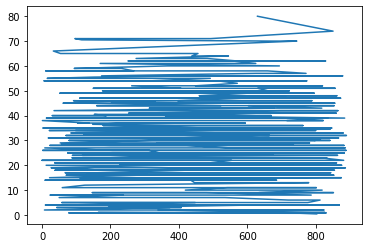

In [54]:
plt.plot(temp['Age'])

<AxesSubplot:xlabel='Age'>

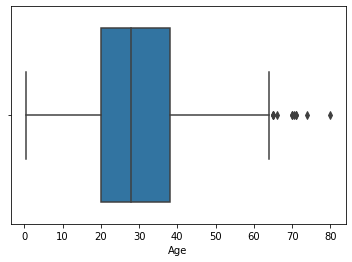

In [55]:
# Check if Age is normally distributed?
sns.boxplot(train['Age'])


In [47]:
stats, p = shapiro(train[~train.Age.isnull()]['Age'])

print('Stats = %.3f , p = %.3f ' % (stats,  p))

#Shapiro-Wilk Test assumes that distribution is not normal

Stats = 0.981 , p = 0.000 


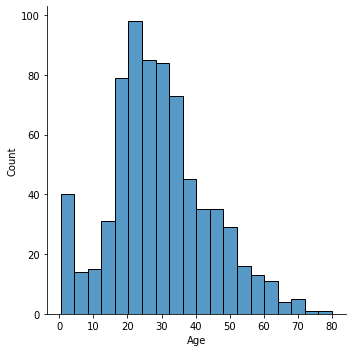

In [33]:
sns.displot(train['Age'])

In [30]:
measurements = np.random.normal(size=150)

<AxesSubplot:>

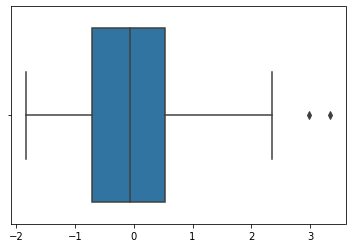

In [32]:
sns.boxplot(measurements)


In [73]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [72]:
train.drop('Cabin', axis=1, inplace=True)

In [74]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [82]:
train = pd.get_dummies(train, columns=['Sex', 'Embarked'], drop_first=True)

In [83]:
train

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,1,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,1,0,0


In [85]:
train.Ticket.nunique()

681

In [93]:
train[train.Ticket == '110465']

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
110,111,0,1,"Porter, Mr. Walter Chamberlain",47.0,0,0,110465,52.0,1,0,1
475,476,0,1,"Clifford, Mr. George Quincy",NaN,0,0,110465,52.0,1,0,1


In [101]:
temp = train[train.duplicated(subset=['Ticket'], keep=False)].sort_values('Ticket').reset_index()

In [104]:
temp.head(50)

,index,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
0,257,258,1,1,"Cherry, Miss. Gladys",30.00,0,0,110152,86.5000,0,0,1
1,759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",33.00,0,0,110152,86.5000,0,0,1
2,504,505,1,1,"Maioni, Miss. Roberta",16.00,0,0,110152,86.5000,0,0,1
3,262,263,0,1,"Taussig, Mr. Emil",52.00,1,1,110413,79.6500,1,0,1
4,558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",39.00,1,1,110413,79.6500,0,0,1
5,585,586,1,1,"Taussig, Miss. Ruth",18.00,0,2,110413,79.6500,0,0,1
6,110,111,0,1,"Porter, Mr. Walter Chamberlain",47.00,0,0,110465,52.0000,1,0,1
7,475,476,0,1,"Clifford, Mr. George Quincy",NaN,0,0,110465,52.0000,1,0,1
8,523,524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",44.00,0,1,111361,57.9792,0,0,0
9,329,330,1,1,"Hippach, Miss. Jean Gertrude",16.00,0,1,111361,57.9792,0,0,0
